In [35]:
# original code from https://pennylane.ai/qml/demos/tutorial_quanvolution.html 
# datasets: https://keras.io/api/datasets/

### Overview of Quanvolutional Neural Networks

#### Classical Convolutional NN
CNNs are a useful classical machine learning tool with a big application in the world of image processing. The way they work is that they use a *convolutational* layer to process smaller parts of an input image. They repeat this process with every small local subsection of the input image, and using the same kernel to compute them all. The results obtained for each region are usually associated to different channels of a single output pixel. The union of all the output pixels produces a new image-like object, which can be further processed by additional layers. [1]

#### Quantum Convolutional NN
In a similar fashion, we can extend the idea of using a variational quantum circuits to achieve the same outcome (with a possible quantum speed-up in the near-term). We can encode a region of the input image into our quantum circuit, and then use a unitary operator as our convolutional layer. Afterwards, we measure the quantum circuit (and be post-processed, or used raw). Each expectation value we obtain can then be mapped to a different channel of a single output pixel (similar to classical convolution). We repeat this until we have processed an entire image.

The main difference with respect to a classical convolution is that a quantum circuit can generate highly complex kernels whose computation could be, at least in principle, classically intractable. [1]


#### Steps for the Quanvolutional Neural Net Algorithm
1. a small region of the input image is embedded into a quantum circuit
2. define and apply our unitary operator (analgous to the classical convolution layer) 
3. measure and obtain the expectation values associated with each pixel
4. repeat 1-3 until the whole input image is processed
5. (optional) the quantum convolution can be followed by further quantum layers or by classical layers.


references:

[1] https://pennylane.ai/qml/demos/tutorial_quanvolution.html

### Image of the Quanvolution Neural Net Process from pennylane:

![alt text](images/qcnn.png "QCNN Circuit")

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 3    # Number of random layers
n_train = 60    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

In [4]:
dev = qml.device("lightning.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi=None):
    # Encoding of 4 classical input values
    for j in range(4):
        angle = float(phi[j] * np.pi)
        #print(type(angle))
        qml.RY(angle, wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [5]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                phi=[image[j, k, 0], image[j, k + 1, 0], image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [6]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
60/60        
Quantum pre-processing of test images:


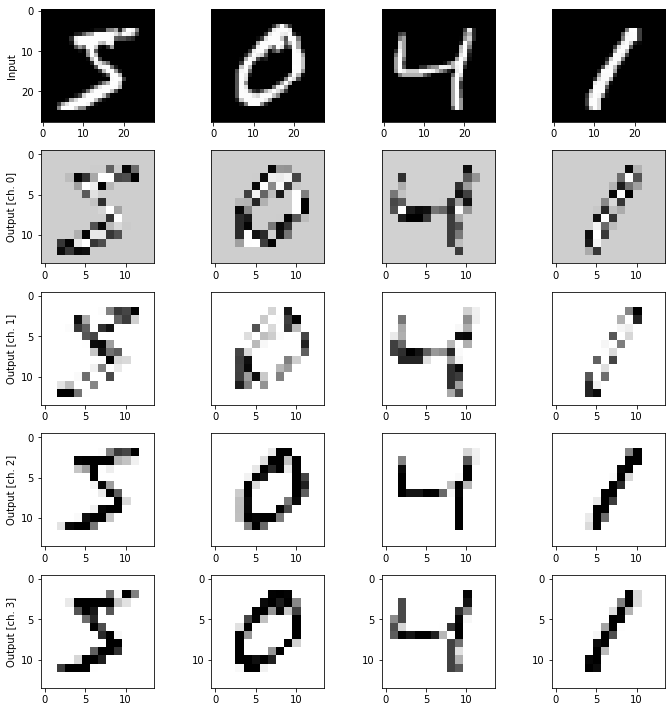

In [7]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [8]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [9]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Train on 60 samples, validate on 30 samples
Epoch 1/30
60/60 - 1s - loss: 2.8843 - accuracy: 0.0333 - val_loss: 2.3712 - val_accuracy: 0.1333
Epoch 2/30
60/60 - 0s - loss: 2.1246 - accuracy: 0.3000 - val_loss: 1.9860 - val_accuracy: 0.2667
Epoch 3/30
60/60 - 0s - loss: 1.5787 - accuracy: 0.5500 - val_loss: 1.8094 - val_accuracy: 0.4667
Epoch 4/30
60/60 - 0s - loss: 1.2851 - accuracy: 0.6667 - val_loss: 1.6129 - val_accuracy: 0.4667
Epoch 5/30
60/60 - 0s - loss: 1.0011 - accuracy: 0.7333 - val_loss: 1.5129 - val_accuracy: 0.5667
Epoch 6/30
60/60 - 0s - loss: 0.7700 - accuracy: 0.9000 - val_loss: 1.3858 - val_accuracy: 0.6333
Epoch 7/30
60/60 - 0s - loss: 0.6488 - accuracy: 0.9500 - val_loss: 1.3666 - val_accuracy: 0.6667
Epoch 8/30
60/60 - 0s - loss: 0.5348 - accuracy: 0.9500 - val_loss: 1.2751 - val_accuracy: 0.6667
Epoch 9/30
60/60 - 0s - loss: 0.4388 - accuracy: 1.0000 - val_loss: 1.2231 - val_accuracy: 0.7000
Epoch 10/30
60/60 - 0s - loss: 0.3920 - accuracy: 0.9833 - val_loss: 1.211

In [10]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Train on 60 samples, validate on 30 samples
Epoch 1/30
60/60 - 1s - loss: 2.4097 - accuracy: 0.1333 - val_loss: 2.3252 - val_accuracy: 0.0667
Epoch 2/30
60/60 - 0s - loss: 1.9619 - accuracy: 0.3667 - val_loss: 2.0486 - val_accuracy: 0.2667
Epoch 3/30
60/60 - 0s - loss: 1.6423 - accuracy: 0.6000 - val_loss: 1.8628 - val_accuracy: 0.5000
Epoch 4/30
60/60 - 0s - loss: 1.3931 - accuracy: 0.7333 - val_loss: 1.6964 - val_accuracy: 0.6333
Epoch 5/30
60/60 - 0s - loss: 1.1747 - accuracy: 0.8500 - val_loss: 1.5751 - val_accuracy: 0.6000
Epoch 6/30
60/60 - 0s - loss: 1.0092 - accuracy: 0.9000 - val_loss: 1.4693 - val_accuracy: 0.7000
Epoch 7/30
60/60 - 0s - loss: 0.8735 - accuracy: 0.9500 - val_loss: 1.4005 - val_accuracy: 0.7000
Epoch 8/30
60/60 - 0s - loss: 0.7663 - accuracy: 0.9500 - val_loss: 1.3381 - val_accuracy: 0.7000
Epoch 9/30
60/60 - 0s - loss: 0.6733 - accuracy: 0.9500 - val_loss: 1.2897 - val_accuracy: 0.7333
Epoch 10/30
60/60 - 0s - loss: 0.5990 - accuracy: 0.9500 - val_loss: 1.244

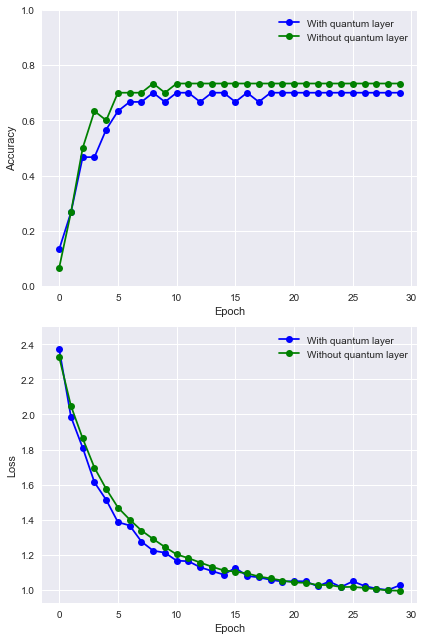

In [11]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()